In [2]:
%pylab inline

from library import lasagnennet as LN
from library import features as F
from library import scale as S
from library import validate as V
import numpy as np
import theano as TH
import pandas as pa
import lasagne as L

Populating the interactive namespace from numpy and matplotlib


In [3]:
train_feats = pa.read_csv('full_train_feats.csv')
train_targets = pa.read_csv('full_train_targets.csv')
val_feats = pa.read_csv('validation_feats.csv')
val_targets = pa.read_csv('validation_targets.csv')
vval_feats = pa.read_csv('val_train_feats.csv')
vval_targets = pa.read_csv('val_train_targets.csv')

In [4]:
tx = np.asarray(train_feats, dtype=np.float32)
tyall = np.asarray(train_targets, dtype=np.float32)
ty = np.asarray(train_targets['LABEL'], dtype=np.float32).reshape(-1, 1)
vx = np.asarray(val_feats, dtype=np.float32)
vyall = np.asarray(val_targets, dtype=np.float32)
vy = np.asarray(val_targets['LABEL'], dtype=np.float32).reshape(-1, 1)

In [5]:
valx = np.asarray(vval_feats, dtype=np.float32)
valyall = np.asarray(vval_targets, dtype=np.int64)

In [6]:
ty = ty.ravel()
vy = vy.ravel()

In [21]:
from sklearn.decomposition import PCA
dimred = PCA(n_components=20, whiten=True)
dimred.fit(tx, ty)

PCA(copy=True, n_components=20, whiten=True)

In [22]:
dtx = dimred.transform(tx)
dvx = dimred.transform(vx)
dvalx = dimred.transform(valx)

In [23]:
print dtx.shape, dvx.shape, dvalx.shape

(628437, 20) (163632, 20) (199971, 20)


In [7]:
print tx.shape, tyall.shape, ty.shape, vx.shape, vyall.shape, vy.shape, valx.shape

(628437, 129) (628437, 4) (628437,) (163632, 129) (163632, 4) (163632,) (199971, 129)


In [12]:
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc_score

In [39]:
clf = svm.SVC(verbose=True, max_iter=200, class_weight={0:1, 1:10})
clf.fit(dtx, ty)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 10}, coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=200, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=True)

In [40]:
# tprobs = clf.decision_function(tx)
vprobs = clf.decision_function(dvx)
valprobs = clf.decision_function(dvalx)

In [42]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, verbose=True, n_jobs=3, max_depth=3)
clf.fit(dtx, ty)

[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:   55.4s remaining:  1.8min
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min finished


RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=100, n_jobs=3,
            oob_score=False, random_state=None, verbose=True)

In [43]:
tprobs = clf.predict_proba(dtx)[:,1]
vprobs = clf.predict_proba(dvx)[:,1]
valprobs = clf.predict_proba(dvalx)[:,1]

[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    3.1s remaining:    6.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.9s finished


In [19]:
print tprobs

[ 0.03918062  0.05856521  0.05856521 ...,  0.02660812  0.02660812
  0.02660812]


0.81849020525


/home/biswajit/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function auc_score is deprecated; Function 'auc_score' has been renamed to 'roc_auc_score' and will be removed in release 0.16.
  warnings.warn(msg, category=DeprecationWarning)


0.837942630118


/home/biswajit/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function auc_score is deprecated; Function 'auc_score' has been renamed to 'roc_auc_score' and will be removed in release 0.16.
  warnings.warn(msg, category=DeprecationWarning)


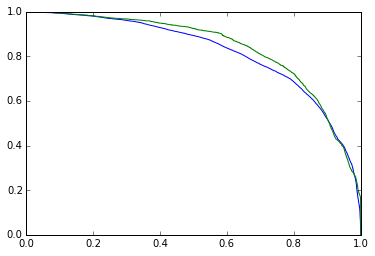

In [44]:
yscore = tprobs.ravel()
fpr, tpr, thresh = roc_curve(ty, yscore)
auc = auc_score(ty, yscore)
print auc
display(pyplot.plot(1-fpr, tpr,))

yscore = vprobs.ravel()
fpr, tpr, thresh = roc_curve(vy, yscore)
auc = auc_score(vy, yscore)
print auc
display(pyplot.plot(1-fpr, tpr,))

In [45]:
# thresh = np.percentile(vprobs.ravel(), 98.5)
thresh = 0.406092323258
print thresh
pred = np.int32(vprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('out.csv', 'w')
outfile.write('ID,TIME,LABEL,ICU\n')
for i in xrange(vx.shape[0]):
    if np.int32(vyall[i,3]) == 1.0:
        outfile.write(str(vyall[i,0])+','+str(vyall[i,1])+','+str(pred[i])+',1\n')
outfile.close()

0.406092323258
8151


In [26]:
# for i in vprobs[np.where(vprobs.ravel()>=thresh)]:
#     print i

In [53]:
print np.percentile(valprobs.ravel(), 99)
print np.percentile(valprobs.ravel(), 99.5)

# thresh = np.percentile(valprobs.ravel(), 98.7)
thresh = 0.37
print thresh
pred = np.int32(valprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('output.csv', 'w')
dids = set()
alltimes = [nan for i in xrange(5000)]
# outfile.write('ID,TIME,LABEL\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+'\n')
        if pred[i] == 1:
            tid = valyall[i,0]
            dids.add(tid)
            if np.isnan(alltimes[tid]):
                alltimes[tid] = valyall[i,1]
            
outfile.close()
print len(dids)
print np.nanmedian(alltimes)/3600

0.381592177462
0.418872504988
0.37
2599
29
63.4980555556


In [46]:
reload(V)
V.validate('out.csv', './Training_Dataset/id_label_train.csv')

tp :  29 , tn :  809 , fp :  5 , fn :  27
sensitivity :  0.517857142857 , specificity :  0.993857493857
accuracy :  0.963218390805 median prediction time :  37.5416666667
finalScore :  51.1962733838


(0.5178571428571429,
 0.9938574938574939,
 0.9632183908045977,
 37.541666666666664,
 51.1962733837734)